In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os, pickle, sys, time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from contextlib import redirect_stdout

In [15]:
import tensorflow as tf
import pickle, sys, time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Conv2D, Add, Multiply
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras import Model

In [3]:
class ResidualUnit():
    def __init__(self, title, filters, activation='relu', use_bias=False, downSample=False):
        if type(filters) == list and len(filters) == 3: # Need 3 filter values for each of 3 bn->relu->conv2d layeres
            self.filters = filters
        else:
            raise Exception("ResidualUnit Error! Please input a list of 3 integers as the unit filters.")
        # stride length, 1 for Attention Module res units, 2 for res units outside of Attention modules
        self.downSample = downSample
        if self.downSample:    
            self.stride = 2
        else:
            self.stride = 1
        self.activation = activation # ReLU default activation type
        self.use_bias = use_bias # Whether to use bias in Conv2D layers, False for now
        self.title = title
        self.layer_names = list()
        for i in range(11):
            self.layer_names.append('ResUnit_L{}_'.format(i+1) + self.title)

        self.bn_1 = BatchNormalization(name = self.layer_names[-11]) # 1st batch normalization layer
        self.activ_1 = Activation(self.activation, name = self.layer_names[-10]) # 1st PRE-ACTIVATION relu layer
        self.conv_1 = Conv2D(name = self.layer_names[-9], filters = self.filters[0], kernel_size=(1,1), strides=(1,1), padding='same', use_bias = self.use_bias) # 1st Conv2D layer
        
        self.bn_2 = BatchNormalization(name = self.layer_names[-8]) # 2nd batch normalization layer
        self.activ_2 = Activation(self.activation, name = self.layer_names[-7]) # 2nd PRE-ACTIVATION relu layer
        self.conv_2 = Conv2D(name = self.layer_names[-6], filters = self.filters[1], kernel_size=(3,3), strides=self.stride, padding='same', use_bias = self.use_bias) # 2nd Conv2D layer

        self.bn_3 = BatchNormalization(name = self.layer_names[-5]) # 3rd batch normalization layer
        self.activ_3 = Activation(self.activation, name = self.layer_names[-4]) # 3rd PRE-ACTIVATION relu layer
        self.conv_3 = Conv2D(name = self.layer_names[-3], filters = self.filters[2], kernel_size=(1,1), strides=(1,1), padding='same', use_bias = self.use_bias) # 3rd Conv2D layer   
        
        # Skip convolutional layer that goes to output
        self.conv_Identity = Conv2D(name = self.layer_names[-2], filters = self.filters[2], kernel_size=(1,1), strides=self.stride, padding='same', use_bias = self.use_bias)
        self.Add_layer = Add(name = self.layer_names[-1]) # Layer for element-wise addition
        
    def forward(self, X):
        self.X_Input = X
        
        # Forward pass through 1st bn->relu->conv segment
        y1 = self.bn_1(self.X_Input) # Batch normalize
        y1 = self.activ_1(y1) # Pre-activation
        self.y_Identity = y1
        y1 = self.conv_1(y1) # Conv Output
        # Forward pass through 2nd bn->relu->conv segment
        y2 = self.bn_2(y1)
        y2 = self.activ_2(y2)
        y2 = self.conv_2(y2)
        # Forward pass through 3rd bn->relu->conv segment
        y3 = self.bn_3(y2)
        y3 = self.activ_3(y3)
        y3 = self.conv_3(y3)
        
        # Skip Conv2D layer operation for Residual operation
        # Verify that the input filter size and conv output size is the same as the output filter size and conv size
        if y3.shape != self.y_Identity.shape or self.strides != 1:
            self.conv_Identity.filters = y3.shape[-1]
            y_Identity_Out = self.conv_Identity(self.y_Identity)
        else:
            y_Identity_Out = self.y_Identity
        # Add the skip connection output
        y_Out = self.Add_layer([y3, y_Identity_Out])
        
        return y_Out # Return results

In [4]:
class ResidualUnit():
    def __init__(self, title, filters, activation='relu', use_bias=False, downSample=False):
        if type(filters) == list and len(filters) == 3: # Need 3 filter values for each of 3 bn->relu->conv2d layeres
            self.filters = filters
        else:
            raise Exception("ResidualUnit Error! Please input a list of 3 integers as the unit filters.")
        # stride length, 1 for Attention Module res units, 2 for res units outside of Attention modules
        self.downSample = downSample
        if self.downSample:    
            self.stride = 2
        else:
            self.stride = 1
        self.activation = activation # ReLU default activation type
        self.use_bias = use_bias # Whether to use bias in Conv2D layers, False for now
        self.title = title
        self.layer_names = list()
        for i in range(11):
            self.layer_names.append('ResUnit_L{}_'.format(i+1) + self.title)

        self.bn_1 = BatchNormalization(name = self.layer_names[-11]) # 1st batch normalization layer
        self.activ_1 = Activation(self.activation, name = self.layer_names[-10]) # 1st PRE-ACTIVATION relu layer
        self.conv_1 = Conv2D(name = self.layer_names[-9], filters = self.filters[0], kernel_size=(1,1), strides=(1,1), padding='same', use_bias = self.use_bias) # 1st Conv2D layer
        
        self.bn_2 = BatchNormalization(name = self.layer_names[-8]) # 2nd batch normalization layer
        self.activ_2 = Activation(self.activation, name = self.layer_names[-7]) # 2nd PRE-ACTIVATION relu layer
        self.conv_2 = Conv2D(name = self.layer_names[-6], filters = self.filters[1], kernel_size=(3,3), strides=self.stride, padding='same', use_bias = self.use_bias) # 2nd Conv2D layer

        self.bn_3 = BatchNormalization(name = self.layer_names[-5]) # 3rd batch normalization layer
        self.activ_3 = Activation(self.activation, name = self.layer_names[-4]) # 3rd PRE-ACTIVATION relu layer
        self.conv_3 = Conv2D(name = self.layer_names[-3], filters = self.filters[2], kernel_size=(1,1), strides=(1,1), padding='same', use_bias = self.use_bias) # 3rd Conv2D layer   
        
        # Skip convolutional layer that goes to output
        self.conv_Identity = Conv2D(name = self.layer_names[-2], filters = self.filters[2], kernel_size=(1,1), strides=self.stride, padding='same', use_bias = self.use_bias)
        self.Add_layer = Add(name = self.layer_names[-1]) # Layer for element-wise addition
        
    def forward(self, X):
        self.X_Input = X
        
        # Forward pass through 1st bn->relu->conv segment
        y1 = self.bn_1(self.X_Input) # Batch normalize
        y1 = self.activ_1(y1) # Pre-activation
        self.y_Identity = y1
        y1 = self.conv_1(y1) # Conv Output
        # Forward pass through 2nd bn->relu->conv segment
        y2 = self.bn_2(y1)
        y2 = self.activ_2(y2)
        y2 = self.conv_2(y2)
        # Forward pass through 3rd bn->relu->conv segment
        y3 = self.bn_3(y2)
        y3 = self.activ_3(y3)
        y3 = self.conv_3(y3)
        
        # Skip Conv2D layer operation for Residual operation
        # Verify that the input filter size and conv output size is the same as the output filter size and conv size
        if y3.shape != self.y_Identity.shape or self.strides != 1:
            self.conv_Identity.filters = y3.shape[-1]
            y_Identity_Out = self.conv_Identity(self.y_Identity)
        else:
            y_Identity_Out = self.y_Identity
        # Add the skip connection output
        y_Out = self.Add_layer([y3, y_Identity_Out])
        
        return y_Out # Return results

In [19]:
class SpecialConvUnit_AttnMod_Mask(): # Special Convolutional Output for Attention Module Mask Branch
    def __init__(self, filters, activation='relu', use_bias=False, attn_mod='1-1'):
        if type(filters) == list and len(filters) == 3:
            self.filters = filters
        else:
            raise Exception("SpecialConvUnit Error! Please input a list of 3 integers as the unit filters (last is used).")
        self.attn_mod=attn_mod
        self.activation = activation # Conv pre-activation
        self.use_bias = use_bias # Default False
        self.count = 0

        self.layer_names = list()

        for i in range(7):
            self.layer_names.append('SpcConv_Mask_L{}_Attn_S{}'.format(i+1, self.attn_mod))
        # 1st Conv segment
        self.bn_1 = BatchNormalization(name=self.layer_names[-7]) # Normalize data
        self.ReLU_1 = Activation(self.activation, name=self.layer_names[-6]) # Pre Activation
        # Conv2D output
        self.conv_1 = Conv2D(name=self.layer_names[-5], filters=self.filters[-1], kernel_size=(1,1),  
                             strides=(1,1), padding='same', use_bias = self.use_bias)
        # 2nd Conv segment
        self.bn_2 = BatchNormalization(name=self.layer_names[-4]) # Normalize data
        self.ReLU_2 = Activation(self.activation, name=self.layer_names[-3])  # Pre Activation
        # Conv2D output
        self.conv_2 = Conv2D(name=self.layer_names[-2], filters=self.filters[-1], kernel_size=(1,1),  
                             strides=(1,1), padding='same', use_bias = self.use_bias)
        # Final sigmoid output
        self.count += 1
        self.Sigmoid_Out = Activation('sigmoid', name=self.layer_names[-1])
        
    def forward(self, X):
        self.X_Input = X
        
        y1 = self.bn_1(self.X_Input)
        y1 = self.ReLU_1(y1)
        y1 = self.conv_1(y1)
        
        y2 = self.bn_2(y1)
        y2 = self.ReLU_2(y2)
        y2 = self.ReLU_2(y2)
        
        y_Out = self.Sigmoid_Out(y2)
        
        return y_Out

In [6]:
class AttentionModule_Stage_01():
    def __init__(self, filters, substage=1, p=1, t=2, r=1, learning_type='ARL', use_bias=False):
        if type(filters) == list and len(filters) == 3:
            self.filters = filters
        else:
            raise Exception("AttentionModule Error! Please input a list of 3 integers as the unit filters.")
        self.substage = substage
        self.p = p
        self.t = t
        self.r = r
        self.learning_type_choices = ['ARL','NAL'] # Attention Module must use either "Naive Attention Learning" or "Attention Residual Learning"
        # If naive (NAL), just multiply trunk and soft mask outputs; if not naive (ARL), multiply trunk and soft mask and add back trunk for output
        if learning_type in self.learning_type_choices:
            self.learning_type = learning_type
        else:
            raise Exception("Entered learning type is invalid!  Please input either 'ARL' or 'NAL'.")

        self.use_bias = use_bias # Choose whether to use bias in Conv2D layers
        self.layer_names = list()
        # Input Residual Unit (res unit), p res units
        self.Res_Input = defaultdict()
        for i in range(self.p):
            title = 'Input-p-{}-{}_AttnS1-{}'.format(self.p, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Input[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) 
        
        # Trunk Branch Res Unit Layer, t trunk res units
        self.Res_Trunk_t=defaultdict()
        for i in range(self.t):
            title = 'Trunk-t-{}-{}_AttnS1-{}'.format(self.t, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Trunk_t[i]= ResidualUnit(title, self.filters, use_bias = self.use_bias) 
        
        # Soft Attention Mask Branch Layers
        title = 'MaxPool_DownSamp-{}_Mask_AttnS1-{}'.format(1, self.substage)
        self.layer_names.append(title)
        self.MaxPool_Down_SM_1 = MaxPool2D(name = title, 
                                           pool_size=(3,3), strides=2, padding="same") # 1st maxpool downsampling operation

        # 1st mask res unit for downsampling segment; Run r times
        self.Res_SM_Down_1r_1 = defaultdict()
        for i in range(self.r):
            title = 'DownSamp-r-{}-{}_Mask_AttnS1-{}'.format(self.r, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_SM_Down_1r_1[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias)
        
        title = 'SkipConn-{}_Mask_AttnS1-{}'.format(1, self.substage)
        self.layer_names.append(title)
        self.Res_SkipCon_SM_1 = ResidualUnit(title, self.filters, use_bias = self.use_bias) # 1st (only) Skip connection res unit 
        
        title = 'MaxPool_DownSamp-{}_Mask_AttnS1-{}'.format(2, self.substage)
        self.layer_names.append(title)
        self.MaxPool_Down_SM_2 = MaxPool2D(name = title, pool_size=(3,3), strides=2, padding="same") # 2nd mask maxpool downsampling operation
        
        # Mask branch middle res units, 2*r res units
        self.Res_SM_Middle_2r = defaultdict()
        for i in range(int(2*self.r)):
            title = 'Mid-2r-{}-{}_Mask_AttnS1-{}'.format(int(2*self.r), i+1, self.substage)
            self.layer_names.append(title)
            self.Res_SM_Middle_2r[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) # Mask branch middle res units, call 2*r times
        
        title = 'UpSamp2D-{}_Mask_AttnS1-{}'.format(1,self.substage)
        self.layer_names.append(title)
        self.UpSampling_Up_SM_1 = UpSampling2D(name=title, size=(2,2)) # 1st mask upsampling operation
        
        title = 'Add_L1_AttnS1-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Add_layer_1 = Add(name=title) # Elementwise Addition layer to add output of downsampling segment res unit to output of 1st UpSampling layer
        
        title = 'Add_L2_AttnS1-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Add_layer_2 = Add(name=title) # Elementwise Addition layer to add output of Skip connection to previous Addition layer

        # 1st mask res unit for upsampling segment; Run r times
        self.Res_SM_Up_1r_2 = defaultdict()
        for i in range(self.r):
            title = 'UpSamp-r-{}-{}_Mask_AttnS1-{}'.format(self.r, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_SM_Up_1r_2[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias)

        title = 'UpSamp2D-{}_Mask_AttnS1-{}'.format(2,self.substage)
        self.layer_names.append(title)
        self.UpSampling_SM_Up_2 = UpSampling2D(name=title, size=(2,2)) # 2nd mask upsampling operation
        
        title = 'Add_L3_AttnS1-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Add_layer_3 = Add(name=title) # Elementwise Addition layer to add Trunk branch to 2nd UpSampling layer

        title = '1-{}'.format(self.substage)
        self.layer_names.append(title)
        self.specialConvOut = SpecialConvUnit_AttnMod_Mask(filters = self.filters, 
                                                           use_bias=self.use_bias,
                                                           attn_mod=title) # Special convolutional layer for Mask branch output
        
        title = 'Mult_L1_AttnS1-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Mult_layer = Multiply(name=title) # Elementwise Multiplication layer to get product of Trunk branch and Special Convolutional Layer
        
        title = 'Add_L4_AttnS1-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Add_layer_4 = Add(name=title) # Elementwise Addition layer to add Trunk layer to previous Multiply layer
        
        # Last output res unit segment, run p times
        self.Res_Output = defaultdict()
        for i in range(self.p):
            title = 'Output-p-{}-{}_AttnS1-{}'.format(self.p, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Output[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) 

    def forward(self, X):
        self.X_Input = X # Input to Attention layer
        # Input Forward Pass: Iterate over p={1} initial Residual Units (res units shorthand)
        for i in range(self.p):
            if i==0:
                Y_Res_Input_1 = self.Res_Input[i].forward(self.X_Input)
            else:
                Y_Res_Input_1 = self.Res_Input[i].forward(Y_Res_Input_1)
        
        # Soft Attention Mask Forward Pass
        Y_SM_1 = self.MaxPool_Down_SM_1(Y_Res_Input_1) # 1st MaxPool for downsampling segment
        for i in range(self.r): # Run r times
            if i==0:
                Y_SM_2 = self.Res_SM_Down_1r_1[i].forward(Y_SM_1) # Pass to skip connection and next max pool layer
            else:
                Y_SM_2 = self.Res_SM_Down_1r_1[i].forward(Y_SM_2)

        Y_SM_3 = self.MaxPool_Down_SM_2(Y_SM_2) # 2nd MaxPool for downsampling segment
        
        # Mask Middle Res Units
        for i in range(int(2*self.r)):
            if i==0:
                Y_SM_4 = self.Res_SM_Middle_2r[i].forward(Y_SM_3)
            else:
                Y_SM_4 = self.Res_SM_Middle_2r[i].forward(Y_SM_4)
        
        Y_SM_5 = self.UpSampling_Up_SM_1(Y_SM_4) # 1st UpSampling output for upsampling segment
        
        Y_SM_6_Add = self.Add_layer_1([Y_SM_2, Y_SM_5]) # Add output of 1st downsampling res unit to previous output
        
        Y_SM_Skip_1 = self.Res_SkipCon_SM_1.forward(Y_SM_2) # Skip connection res unit output
        
        Y_SM_7_SkipAdd = self.Add_layer_2([Y_SM_6_Add,Y_SM_Skip_1]) # Add skip connection output to previous output
        
        for i in range(self.r):
          if i==0:
              Y_SM_8 = self.Res_SM_Up_1r_2[i].forward(Y_SM_7_SkipAdd) # Output of 1st upsampling res unit
          else:
              Y_SM_8 = self.Res_SM_Up_1r_2[i].forward(Y_SM_8)

        Y_SM_9 = self.UpSampling_SM_Up_2(Y_SM_8) # 2nd UpSampling output for upsampling segment
        
        # Trunk branch
        for i in range(self.t):
            if i==0:
                Y_Trunk_1 = self.Res_Trunk_t[i].forward(Y_Res_Input_1) # Trunk output
            else:
                Y_Trunk_1 = self.Res_Trunk_t[i].forward(Y_Trunk_1) # Trunk output
        
        Y_SM_10_Add = self.Add_layer_3([Y_SM_9,Y_Trunk_1]) # Add trunk output to mask layer before special convolution
        
        Y_SM_11_SpecConv = self.specialConvOut.forward(Y_SM_10_Add) # Output of special convolution unit
        
        Y_Combined_1 = self.Mult_layer([Y_SM_11_SpecConv, Y_Trunk_1]) # Prodcut of Trunk branch and Special Convolution Layer
        
        # If 'ARL', add trunk output to product of trunk output and special convolution output
        if self.learning_type == self.learning_type_choices[0]:
            Y_Combined_2 = self.Add_layer_4([Y_Combined_1, Y_Trunk_1])
        # If 'NAL', just keep product of trunk output and special convolution layer
        elif self.learning_type == self.learning_type_choices[-1]:
            Y_Combined_2 = Y_Combined_1
        
        for i in range(self.p): # Get p output res units
            if i==0:
                Y_Out = self.Res_Output[i].forward(Y_Combined_2) # Pass mask and trunk output
            else:
                Y_Out = self.Res_Output[i].forward(Y_Out) # Pass last output res unit result
        
        return Y_Out # Return Final Output

In [7]:
class AttentionModule_Stage_02():
    def __init__(self, filters, substage=1, p=1, t=2, r=1, learning_type='ARL', use_bias=False):
        if type(filters) == list and len(filters) == 3:
            self.filters = filters
        else:
            raise Exception("AttentionModule Error! Please input a list of 3 integers as the unit filters.")
        self.substage = substage
        self.p = p
        self.t = t
        self.r = r
        self.learning_type_choices = ['ARL','NAL'] # Attention Module must use either "Naive Attention Learning" or "Attention Residual Learning"
        # If naive (NAL), just multiply trunk and soft mask outputs; if not naive (ARL), multiply trunk and soft mask and add back trunk for output
        if learning_type in self.learning_type_choices:
            self.learning_type = learning_type
        else:
            raise Exception("Entered learning type is invalid!  Please input either 'ARL' or 'NAL'.")

        self.use_bias = use_bias # Choose whether to use bias in Conv2D layers
        self.layer_names = list()
        # Input Residual Unit (res unit), p res units
        self.Res_Input = defaultdict()
        
        for i in range(self.p):
            title = 'Input-p-{}-{}_AttnS2-{}'.format(self.p, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Input[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) 
        
        # Trunk Branch Res Unit Layer, t trunk res units
        self.Res_Trunk_t = defaultdict()
        for i in range(self.t):
            title = 'Trunk-t-{}-{}_AttnS2-{}'.format(self.t, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Trunk_t[i]= ResidualUnit(title, self.filters, use_bias = self.use_bias) 
        
        # Soft Attention Mask Branch Layers
        title = 'MaxPool_DownSamp-{}_Mask_AttnS2-{}'.format(1, self.substage)
        self.layer_names.append(title)
        self.MaxPool_Down_SM_1 = MaxPool2D(name=title, pool_size=(3,3), strides=2, padding="same") # Maxpool downsampling operation
        
        # Mask branch middle res units, 2*r res units
        self.Res_SM_Middle_2r = defaultdict()
        for i in range(int(2*self.r)):
            title = 'UpSamp-r-{}-{}_Mask_AttnS2-{}'.format(self.r, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_SM_Middle_2r[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) # Mask branch middle res units, call 2*r times
        
        title = 'UpSamp2D-{}_Mask_AttnS2-{}'.format(1,self.substage)
        self.layer_names.append(title)
        self.UpSampling_Up_SM_1 = UpSampling2D(name=title, size=(2,2)) # 1st mask upsampling operation
        
        title = 'Add_L1_AttnS2-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Add_layer_1 = Add(name=title) # Elementwise Addition layer to add Trunk branch output to previous UpSampling output

        title = '2-{}'.format(self.substage)
        self.layer_names.append(title)
        self.specialConvOut = SpecialConvUnit_AttnMod_Mask(filters = self.filters, 
                                                            use_bias=self.use_bias, 
                                                            attn_mod=title) # Special convolutional layer for Mask branch output
        
        title = 'Mult_L1_AttnS2-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Mult_layer = Multiply(name=title) # Elementwise Multiplication layer to get product of Trunk branch and Special Convolutional Layer
        
        title = 'Add_L2_AttnS2-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Add_layer_2 = Add(name=title) # Elementwise Addition layer to add Trunk layer to previous Multiply layer
       
        # Last output res unit segment, run p times
        self.Res_Output = defaultdict()
        for i in range(self.p):
            title = 'Output-p-{}-{}_AttnS2-{}'.format(self.p, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Output[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) 

    def forward(self, X):
        self.X_Input = X # Input to Attention layer
        # Input Forward Pass: Iterate over p={1} initial Residual Units (res units shorthand)
        for i in range(self.p):
            if i==0:
                Y_Res_Input_1 = self.Res_Input[i].forward(self.X_Input)
            else:
                Y_Res_Input_1 = self.Res_Input[i].forward(Y_Res_Input_1)
        
        # Soft Attention Mask Forward Pass
        Y_SM_1 = self.MaxPool_Down_SM_1(Y_Res_Input_1) # MaxPool for downsampling segment
        
        # Mask Middle Res Units
        for i in range(int(2*self.r)):
            if i==0:
                Y_SM_2 = self.Res_SM_Middle_2r[i].forward(Y_SM_1)
            else:
                Y_SM_2 = self.Res_SM_Middle_2r[i].forward(Y_SM_2)
        
        Y_SM_3 = self.UpSampling_Up_SM_1(Y_SM_2) # UpSampling output for upsampling segment
        
        # Trunk branch
        for i in range(self.t):
            if i==0:
                Y_Trunk_1 = self.Res_Trunk_t[i].forward(Y_Res_Input_1) # Trunk output
            else:
                Y_Trunk_1 = self.Res_Trunk_t[i].forward(Y_Trunk_1) # Trunk output

        Y_SM_4_Add = self.Add_layer_1([Y_SM_3, Y_Trunk_1]) # Add output of 1st downsampling res unit to previous output
        
        Y_SM_5_SpecConv = self.specialConvOut.forward(Y_SM_4_Add) # Output of special convolution unit
        
        Y_Combined_1 = self.Mult_layer([Y_SM_5_SpecConv, Y_Trunk_1]) # Product of Trunk branch and Special Convolution Layer
        
        # If 'ARL', add trunk output to product of trunk output and special convolution output
        if self.learning_type == self.learning_type_choices[0]:
            Y_Combined_2 = self.Add_layer_2([Y_Combined_1, Y_Trunk_1])
        # If 'NAL', just keep product of trunk output and special convolution layer
        elif self.learning_type == self.learning_type_choices[-1]:
            Y_Combined_2 = Y_Combined_1
        
        for i in range(self.p): # Get p output res units
            if i==0:
                Y_Out = self.Res_Output[i].forward(Y_Combined_2) # Pass mask and trunk output
            else:
                Y_Out = self.Res_Output[i].forward(Y_Out) # Pass last output res unit result
        
        return Y_Out # Return Final Output

In [8]:
class AttentionModule_Stage_03():
    def __init__(self, filters, substage=1, p=1, t=2, r=1, learning_type='ARL', use_bias=False):
        if type(filters) == list and len(filters) == 3:
            self.filters = filters
        else:
            raise Exception("AttentionModule Error! Please input a list of 3 integers as the unit filters.")
        self.substage = substage
        self.p = p
        self.t = t
        self.r = r
        self.learning_type_choices = ['ARL','NAL'] # Attention Module must use either "Naive Attention Learning" or "Attention Residual Learning"
        # If naive (NAL), just multiply trunk and soft mask outputs; if not naive (ARL), multiply trunk and soft mask and add back trunk for output
        if learning_type in self.learning_type_choices:
            self.learning_type = learning_type
        else:
            raise Exception("Entered learning type is invalid!  Please input either 'ARL' or 'NAL'.")

        self.use_bias = use_bias # Choose whether to use bias in Conv2D layers
        self.layer_names = list()

        # Input Residual Unit (res unit), p res units
        self.Res_Input = defaultdict()
        for i in range(self.p):
            title = 'Input-p-{}-{}_AttnS3-{}'.format(self.p, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Input[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) 
        
        # Trunk Branch Res Unit Layer, t trunk res units
        self.Res_Trunk_t = defaultdict()
        for i in range(self.t):
            title = 'Trunk-t-{}-{}_AttnS3-{}'.format(self.t, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Trunk_t[i]= ResidualUnit(title, self.filters, use_bias = self.use_bias) 
        
        # Mask branch middle res units, 2*r res units
        self.Res_SM_Middle_2r = defaultdict()
        for i in range(int(2*self.r)):
            title = 'UpSamp-r-{}-{}_Mask_AttnS3-{}'.format(self.r, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_SM_Middle_2r[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) # Mask branch middle res units, call 2*r times
        
        title = '3-{}'.format(self.substage)
        self.layer_names.append(title)
        self.specialConvOut = SpecialConvUnit_AttnMod_Mask(filters = self.filters, use_bias=self.use_bias, attn_mod=title) # Special convolutional layer for Mask branch output
        
        title = 'Mult_L1_AttnS3-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Mult_layer = Multiply(name=title) # Elementwise Multiplication layer to get product of Trunk branch and Special Convolutional Layer
        
        title = 'Add_L1_AttnS3-{}'.format(self.substage)
        self.layer_names.append(title)
        self.Add_layer_1 = Add(name=title) # Elementwise Addition layer to add Trunk branch output to previous UpSampling output
       
        # Last output res unit segment, run p times
        self.Res_Output = defaultdict()
        for i in range(self.p):
            title = 'Output-p-{}-{}_AttnS3-{}'.format(self.p, i+1, self.substage)
            self.layer_names.append(title)
            self.Res_Output[i] = ResidualUnit(title, self.filters, use_bias = self.use_bias) 

    def forward(self, X):
        self.X_Input = X # Input to Attention layer
        # Input Forward Pass: Iterate over p={1} initial Residual Units (res units shorthand)
        for i in range(self.p):
            if i==0:
                Y_Res_Input_1 = self.Res_Input[i].forward(self.X_Input)
            else:
                Y_Res_Input_1 = self.Res_Input[i].forward(Y_Res_Input_1)
        
        # Mask Middle Res Units
        for i in range(int(2*self.r)):
            if i==0:
                Y_SM_1 = self.Res_SM_Middle_2r[i].forward(Y_Res_Input_1)
            else:
                Y_SM_1 = self.Res_SM_Middle_2r[i].forward(Y_SM_1)
        
        # Trunk branch
        for i in range(self.t):
            if i==0:
                Y_Trunk_1 = self.Res_Trunk_t[i].forward(Y_Res_Input_1) # Trunk output
            else:
                Y_Trunk_1 = self.Res_Trunk_t[i].forward(Y_Trunk_1) # Trunk output

        Y_SM_2_SpecConv = self.specialConvOut.forward(Y_SM_1) # Output of special convolution unit

        Y_Combined_1 = self.Mult_layer([Y_SM_2_SpecConv, Y_Trunk_1]) # Product of Trunk branch and Special Convolution Layer
        
        # If 'ARL', add trunk output to product of trunk output and special convolution output
        if self.learning_type == self.learning_type_choices[0]:
            Y_Combined_2 = self.Add_layer_1([Y_Combined_1, Y_Trunk_1])
        # If 'NAL', just keep product of trunk output and special convolution layer
        elif self.learning_type == self.learning_type_choices[-1]:
            Y_Combined_2 = Y_Combined_1
        # Output Forward Pass: Iterate over p={1} initial Residual Units (res units shorthand)
        for i in range(self.p): 
            if i==0:
                Y_Out = self.Res_Output[i].forward(Y_Combined_2) # Pass mask and trunk output
            else:
                Y_Out = self.Res_Output[i].forward(Y_Out) # Pass last output res unit result
        
        return Y_Out # Return Final Output

In [9]:
class ResidualAttentionModel_56():
    def __init__(self, input_shape, output_classes, filter_base=[128,256,512,1024], 
                 activation='relu', p=1, t=2, r=1, learning_type='ARL', use_bias=False):
        self.input_shape = input_shape
        self.output_classes = output_classes
        if type(filter_base) == list and len(filter_base) == 4:
            self.filter_dict = {'1':[filter_base[0]//4, filter_base[0]//4, filter_base[0]],
                                '2':[filter_base[1]//4, filter_base[1]//4, filter_base[1]],
                                '3':[filter_base[2]//4, filter_base[2]//4, filter_base[2]],
                                'Out':[filter_base[3]//4, filter_base[3]//4, filter_base[3]]}
        else:
            raise Exception("RAN Filter List Error! Please input a list of 4 integers as the unit filter base.")
        self.activation = activation
        self.p = p
        self.t = t
        self.r = r
        self.learning_type_choices = ['ARL','NAL'] # Attention Module must use either "Naive Attention Learning" or "Attention Residual Learning"
        # If naive (NAL), just multiply trunk and soft mask outputs; if not naive (ARL), multiply trunk and soft mask and add back trunk for output
        if learning_type in self.learning_type_choices:
            self.learning_type = learning_type
        else:
            raise Exception("Entered learning type is invalid!  Please input either 'ARL' or 'NAL'.")

        self.use_bias = use_bias # Choose whether to use bias in Conv2D layers
        
        self.Model_Input = Input(name='Model_Input', shape = self.input_shape)
        
        self.Conv_Input = Conv2D(name='Conv1_In', filters=32, kernel_size=(3,3), padding='same', use_bias=self.use_bias)
        self.BN_Input = BatchNormalization(name='BN_In')
        self.ReLU_Input = Activation('relu', name='ReLU_In')
        
        self.Res_NotAttnMod_1 = ResidualUnit(title='NotAttnModule_1_NoDS', filters=self.filter_dict['1'], activation = self.activation,
                                             use_bias = self.use_bias, downSample=False)
        
        self.AttnMod_1 = AttentionModule_Stage_01(filters=self.filter_dict['1'], substage=1,
                                                  p=self.p, t=self.t, r=self.r, 
                                                  learning_type=self.learning_type, use_bias=self.use_bias)
        
        self.Res_NotAttnMod_2 = ResidualUnit(title='NotAttnModule_2_DS', filters=self.filter_dict['2'],
                                             activation = self.activation,
                                             use_bias = self.use_bias, downSample=True)
        
        self.AttnMod_2 = AttentionModule_Stage_02(filters=self.filter_dict['2'],  substage=1,
                                                  p=self.p, t=self.t, r=self.r, 
                                                  learning_type=self.learning_type, use_bias=self.use_bias)
        
        self.Res_NotAttnMod_3 = ResidualUnit(title='NotAttnModule_3_DS', filters=self.filter_dict['3'], activation = self.activation,
                                             use_bias = self.use_bias, downSample=True)
        
        self.AttnMod_3 = AttentionModule_Stage_03(filters=self.filter_dict['3'], substage=1,
                                                  p=self.p, t=self.t, r=self.r, 
                                                  learning_type=self.learning_type, use_bias=self.use_bias)
        
        self.Res_NotAttnMod_4 = ResidualUnit(title='NotAttnModule_4_NoDS', filters=self.filter_dict['Out'], activation = self.activation,
                                             use_bias = self.use_bias, downSample=False)
        self.Res_NotAttnMod_5 = ResidualUnit(title='NotAttnModule_5_NoDS', filters=self.filter_dict['Out'], activation = self.activation,
                                             use_bias = self.use_bias, downSample=False)
        self.Res_NotAttnMod_6 = ResidualUnit(title='NotAttnModule_6_NoDS', filters=self.filter_dict['Out'], activation = self.activation,
                                             use_bias = self.use_bias, downSample=False)
        self.BN_Out = BatchNormalization(name='BN_Out')
        self.ReLU_Out = Activation('relu', name='ReLU_Out')
        self.AvgPool_Out = AveragePooling2D(name='AvgPool_Out')
        
        self.Flatten_Out = Flatten(name='Flatten_Out')
        
        self.Dense_Out = Dense(name='Final_Out', units = self.output_classes, activation='softmax')
        
    def return_Model(self):
        
        X_Input = self.Model_Input
        
        Y_Conv_Input = self.Conv_Input(X_Input)
        
        Y_BN_Input = self.BN_Input(Y_Conv_Input)
        
        Y_ReLU_Input = self.ReLU_Input(Y_BN_Input)
        
        Y_Res_NA_1 = self.Res_NotAttnMod_1.forward(Y_ReLU_Input)
        
        Y_AttnMod_1 = self.AttnMod_1.forward(Y_Res_NA_1)
        
        Y_Res_NA_2 = self.Res_NotAttnMod_2.forward(Y_AttnMod_1)
        
        Y_AttnMod_2 = self.AttnMod_2.forward(Y_Res_NA_2)
        
        Y_Res_NA_3 = self.Res_NotAttnMod_3.forward(Y_AttnMod_2)
        
        Y_AttnMod_3 = self.AttnMod_3.forward(Y_Res_NA_3)
        
        Y_Res_NA_4 = self.Res_NotAttnMod_4.forward(Y_AttnMod_3)
        
        Y_Res_NA_5 = self.Res_NotAttnMod_5.forward(Y_Res_NA_4)
        
        Y_Res_NA_6 = self.Res_NotAttnMod_6.forward(Y_Res_NA_5)
        
        Y_BN_Out = self.BN_Out(Y_Res_NA_6)
        Y_ReLU_Out = self.ReLU_Out(Y_BN_Out)
        
        self.AvgPool_Out.pool_size = (Y_ReLU_Out.shape[-3], Y_ReLU_Out.shape[-2])
        Y_AvgPoolOut = self.AvgPool_Out(Y_ReLU_Out)
        
        Y_Flatten_Out = self.Flatten_Out(Y_AvgPoolOut)
        
        Y_Dense_Out = self.Dense_Out(Y_Flatten_Out)

        model = Model(inputs = X_Input, outputs = Y_Dense_Out)        
        
        return model

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print(gpus)

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
path = './models'
model_name = '/ran56_v2'
model_path = path + model_name
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print(model_path)
else:
    print(model_path + ' already exists.')

history_path = model_path + '/history'
if not os.path.exists(history_path):
    os.makedirs(history_path)
    print(history_path)
else:
    print(history_path + ' already exists.')

saved_model_path = model_path + '/saved_models'
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)
    print(saved_model_path)
else:
    print(saved_model_path + ' already exists.')

graph_path = model_path + '/graphs'
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
    print(graph_path)
else:
    print(graph_path + ' already exists.')

./models/ran56_v2
./models/ran56_v2/history
./models/ran56_v2/saved_models
./models/ran56_v2/graphs


In [12]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

170508288/170498071 [==============================] - 6s 0us/step


In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          horizontal_flip=True,
                                                          validation_split=0.2)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train - X_train.mean()
X_test = X_test - X_test.mean()

datagen.fit(X_train)

In [20]:
input_shape = X_train.shape[1:]
output_classes = 10

ran56 = ResidualAttentionModel_56(input_shape, output_classes)

model = ran56.return_Model()

model.compile(tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Model_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1_In (Conv2D)              (None, 32, 32, 32)   864         ['Model_Input[0][0]']            
                                                                                                  
 BN_In (BatchNormalization)     (None, 32, 32, 32)   128         ['Conv1_In[0][0]']               
                                                                                                  
 ReLU_In (Activation)           (None, 32, 32, 32)   0           ['BN_In[0][0]']                  
                                                                                              

In [21]:
dot_img_file = '/tmp/ran56_v2.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [22]:
earlyStopping_TrainAcc = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
callbacks = list()
callbacks.append(earlyStopping_TrainAcc)

In [23]:
ran56_v2_history = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'), validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
                    epochs=200, callbacks=callbacks)

Epoch 1/200
625/625 [==============================] - 75s 92ms/step - loss: 1.7773 - accuracy: 0.3277 - val_loss: 2.2949 - val_accuracy: 0.3071
Epoch 2/200
625/625 [==============================] - 56s 89ms/step - loss: 1.4553 - accuracy: 0.4631 - val_loss: 1.8880 - val_accuracy: 0.3683
Epoch 3/200
625/625 [==============================] - 56s 89ms/step - loss: 1.2832 - accuracy: 0.5328 - val_loss: 1.8555 - val_accuracy: 0.4202
Epoch 4/200
625/625 [==============================] - 56s 89ms/step - loss: 1.1629 - accuracy: 0.5833 - val_loss: 2.6684 - val_accuracy: 0.4181
Epoch 5/200
625/625 [==============================] - 56s 89ms/step - loss: 1.0533 - accuracy: 0.6256 - val_loss: 1.2859 - val_accuracy: 0.5728
Epoch 6/200
625/625 [==============================] - 56s 89ms/step - loss: 0.9847 - accuracy: 0.6508 - val_loss: 1.2468 - val_accuracy: 0.5742
Epoch 7/200
625/625 [==============================] - 55s 88ms/step - loss: 0.9159 - accuracy: 0.6782 - val_loss: 1.0171 - val_ac

In [24]:
plot_loss_filename = graph_path + '/ran56_v2_Loss.png'
print(plot_loss_filename)
plot_acc_filename = graph_path + '/ran56_v2_Accuracy.png'
print(plot_acc_filename)

./models/ran56_v2/graphs/ran56_v2_Loss.png
./models/ran56_v2/graphs/ran56_v2_Accuracy.png


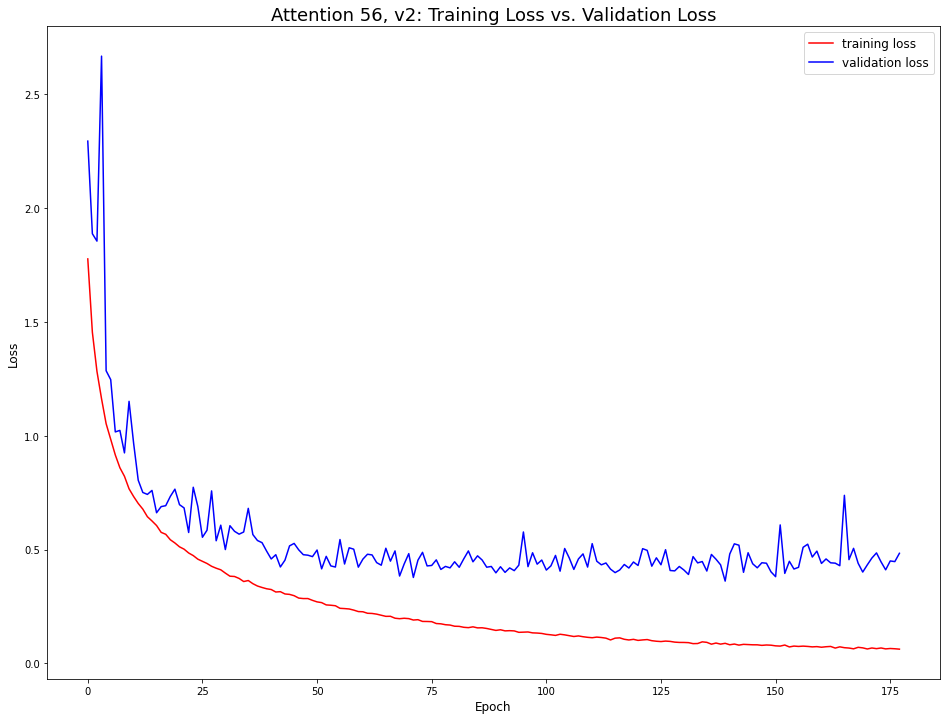

In [25]:
plt.figure(figsize=(16,12))
plt.title("Attention 56, v2: Training Loss vs. Validation Loss", fontsize=18)
plt.plot(ran56_v2_history.history['loss'], label='training loss', color='red')
plt.plot(ran56_v2_history.history['val_loss'], label = 'validation loss', color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_loss_filename)
plt.show()

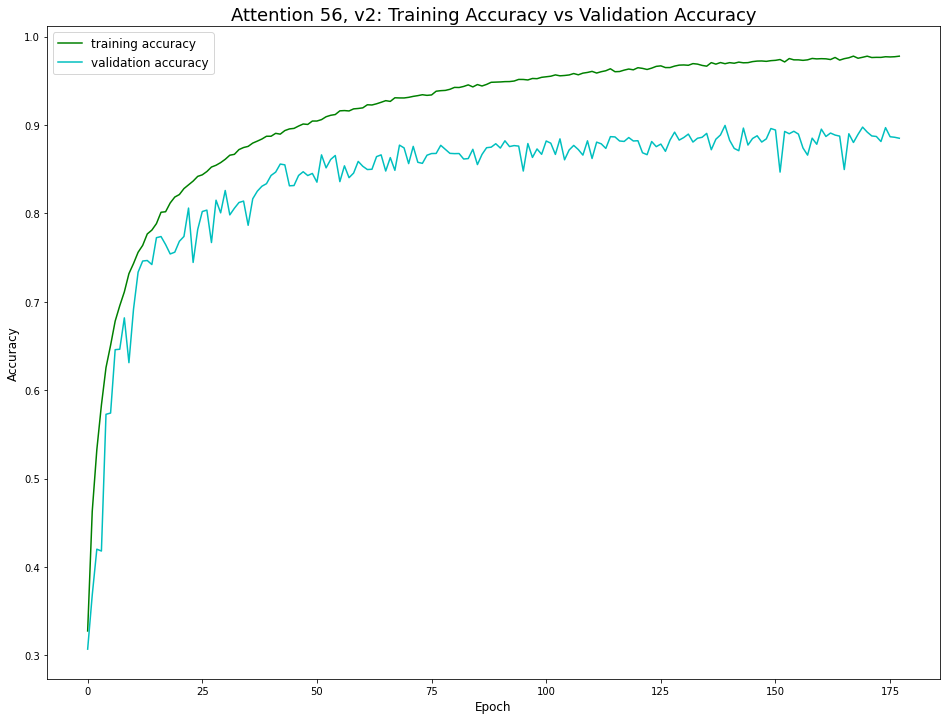

In [26]:
plt.figure(figsize=(16,12))
plt.title("Attention 56, v2: Training Accuracy vs Validation Accuracy", fontsize=18)
plt.plot(ran56_v2_history.history['accuracy'], label='training accuracy', color='g')
plt.plot(ran56_v2_history.history['val_accuracy'], label = 'validation accuracy', color='c')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_acc_filename)
plt.show()

In [39]:
os.getcwd()

'/content'

In [47]:
history_path = '/content/models/ran56_v2/history/ran56_v2_history'

In [45]:
import pickle

In [48]:
with open(history_path, 'wb') as file_pi:
        pickle.dump(ran56_v2_history.history, file_pi)

In [55]:
model_path = './models/ran56_v2/saved_models'

In [56]:
model.save(model_path)

INFO:tensorflow:Assets written to: ./models/ran56_v2/saved_models/assets


INFO:tensorflow:Assets written to: ./models/ran56_v2/saved_models/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
